In [2]:
import torch
from torch import nn
from d2l import torch as d2l

In [66]:
class LinearRegressionScratch(d2l.Module) : 
    """ Linear Regression from Scratch """
    def __init__(self, num_inputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.w = torch.normal(0, sigma, (num_inputs, 1), requires_grad=True)
        self.b = torch.zeros(1, requires_grad=True)

    def forward(self, X):
        return torch.matmul(X, self.w) + self.b
    
    def loss(self, y_hat, y):
        l = (y_hat - y) ** 2 / 2
        return l.sum()
    
    def configure_optimizers(self):
        return SGD([self.w, self.b], self.lr)
    

class SGD(d2l.HyperParameters):  #@save
    """Minibatch stochastic gradient descent."""
    def __init__(self, params, lr):
        self.save_hyperparameters()

    def step(self):
        for param in self.params:
            param -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

@d2l.add_to_class(d2l.Trainer)  #@save
def prepare_batch(self, batch):
    return batch

@d2l.add_to_class(d2l.Trainer)  #@save
def fit_epoch(self):
    self.model.train()
    for batch in self.train_dataloader:
        loss = self.model.training_step(self.prepare_batch(batch))
        self.optim.zero_grad()
        with torch.no_grad():
            loss.backward()
            if self.gradient_clip_val > 0:  # To be discussed later
                self.clip_gradients(self.gradient_clip_val, self.model)
            self.optim.step()
        self.train_batch_idx += 1
    if self.val_dataloader is None:
        return
    self.model.eval()
    for batch in self.val_dataloader:
        with torch.no_grad():
            self.model.validation_step(self.prepare_batch(batch))
        self.val_batch_idx += 1

Each epoch is basically going through the dataset all at once. 
1. $(\mathbf{w}, b)$
2. Repeat until done : 
   1. $\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
   2. $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$

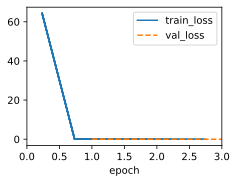

In [67]:
model = LinearRegressionScratch(num_inputs=2, lr=0.01)
data = d2l.SyntheticRegressionData(w = torch.tensor([2, -3.4]), b = 4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

In [68]:
with torch.no_grad() : 
    print(f"error in estimating w : {data.w - model.w.reshape(data.w.shape)}")
    print(f"error in estimating b : {data.b - model.b}")


error in estimating w : tensor([-0.0005, -0.0004])
error in estimating b : tensor([0.0011])


### Concise implementation

In [69]:
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [70]:
class LinearRegression(d2l.Module) : 
    def __init__(self, lr) : 
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.LazyLinear(1) # 1 Layer net
        self.net.weight.data.normal_(0, 0.01) # Initialization Weight
        self.net.bias.data.fill_(0) # Initialization Bias
    
    def forward(self, X) : 
        return self.net(X)
    
    def loss(self, yhat, y) : 
        fn = nn.MSELoss()
        return fn(yhat, y)
    
    def get_w_b(self):
        return (self.net.weight.data, self.net.bias.data)
    
    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), self.lr)

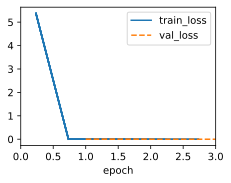

In [71]:
model = LinearRegression(lr=0.1)   
data = d2l.SyntheticRegressionData(w = torch.tensor([2, -3.4]), b = 4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

In [76]:
w,b = model.get_w_b()

print(f"error in estimating w : {data.w - w.reshape(data.w.shape)}")
print(f"error in estimating b : {data.b - b}")


error in estimating w : tensor([0.0005, 0.0006])
error in estimating b : tensor([-0.0008])


#### Weight Decay

$y = 0.05 + \sum_{i = 1}^d 0.01 x_i + \epsilon \textrm{ where }
\epsilon \sim \mathcal{N}(0, 0.01^2).$

y is the generated data. 

In [32]:
class Data(d2l.DataModule):
    def __init__(self, num_train, num_val, num_inputs, batch_size):
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, num_inputs)
        noise = torch.randn(n, 1) * 0.01
        w, b = torch.ones((num_inputs, 1)) * 0.01, 0.05
        self.y = torch.matmul(self.X, w) + b + noise

    def get_dataloader(self, train):
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.X, self.y], train, i)

def l2_penalty(w):
    return (w ** 2).sum() / 2

class WeightDecayScratch(d2l.LinearRegressionScratch):
    def __init__(self, num_inputs, lambd, lr, sigma=0.01):
        super().__init__(num_inputs, lr, sigma)
        self.save_hyperparameters()

    def loss(self, y_hat, y):
        return (super().loss(y_hat, y) +
                self.lambd * l2_penalty(self.w))


In [44]:
data = Data(num_train=20, num_val=100, num_inputs=200, batch_size=5)
trainer = d2l.Trainer(max_epochs=10)

def train_scratch(lambd):
    model = WeightDecayScratch(num_inputs=200, lambd=lambd, lr=0.01)
    model.board.yscale='log'
    trainer.fit(model, data)
    print('L2 norm of w:', float(l2_penalty(model.w)))



L2 norm of w: 0.001405979273840785


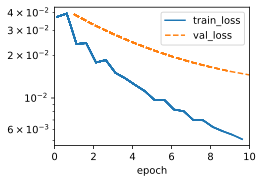

In [45]:
train_scratch(3)

#### Concise Implementation


In [47]:
class WeightDecay(d2l.LinearRegression):
    def __init__(self, wd, lr):
        super().__init__(lr)
        self.save_hyperparameters()
        self.wd = wd

    def configure_optimizers(self):
        return torch.optim.SGD([
            {'params': self.net.weight, 'weight_decay': self.wd},
            {'params': self.net.bias}], self.lr)

L2 norm of w: 0.014568665064871311


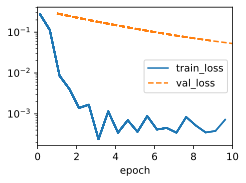

In [48]:
model = WeightDecay(wd=3, lr=0.01)
model.board.yscale='log'
trainer.fit(model, data)
print('L2 norm of w:', float(l2_penalty(model.net.weight.data)))